In [ ]:
!pip install sentencepiece

In [2]:
from transformers import TFT5ForConditionalGeneration, T5Tokenizer
import tensorflow as tf
import pandas as pd

In [3]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = TFT5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

C:\Users\jasmi\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jasmi\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [6]:
# @title Default title text
df = pd.read_csv(r"C:\Users\jasmi\Projects\Final Project\PoliceTraining-Final\training_dataset.csv")

In [7]:
input_encodings = tokenizer(
    list(df["Bodycam Transcript"]), truncation=True, padding="max_length", max_length=512, return_tensors="tf"
)
label_encodings = tokenizer(
    list(df["Success/Failure"].astype(str)), truncation=True, padding="max_length", max_length=512, return_tensors="tf"
)

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "decoder_input_ids": label_encodings["input_ids"]  # Add decoder input IDs
    },
    label_encodings["input_ids"]  # Target labels remain the same
))
dataset = dataset.shuffle(1000).batch(16)

In [46]:
def custom_loss_function(labels, logits):
  """Custom loss function that calculates the loss between labels and logits."""
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction=tf.keras.losses.Reduction.NONE
  )
  # Create a mask to ignore padding tokens in the labels
  # Changed line: use tf.float32 instead of loss_fn.dtype
  mask = tf.cast(labels != 0, dtype=tf.float32)  # Assuming 0 is the padding token ID

  loss = loss_fn(labels, logits)
  loss *= mask  # Apply the mask to the loss
  return tf.reduce_mean(loss)  # Calculate the mean

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=custom_loss_function) # Use custom_loss_function

In [48]:
model.fit(dataset, epochs=3)

Epoch 1/3



KeyboardInterrupt


KeyboardInterrupt: 

In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Bodycam Transcript"],  # Input text
    df["Success/Failure"],     # Target labels
    test_size=0.2,             # 20% for validation/testing
    random_state=42
)

In [14]:
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding="max_length", max_length=512, return_tensors="tf"
)

predictions = []
for i in range(len(val_texts)):
    input_ids = val_encodings["input_ids"][i:i+1]
    attention_mask = val_encodings["attention_mask"][i:i+1]
    output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10)
    pred = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(pred.strip().lower())

In [41]:
predicted_labels = [1 if pred == "success" else 0 for pred in predictions]

true_labels = list(val_labels)



In [42]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 57.00%


In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Failure", "Success"]))

Classification Report:
              precision    recall  f1-score   support

     Failure       0.57      1.00      0.73       114
     Success       0.00      0.00      0.00        86

    accuracy                           0.57       200
   macro avg       0.28      0.50      0.36       200
weighted avg       0.32      0.57      0.41       200



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


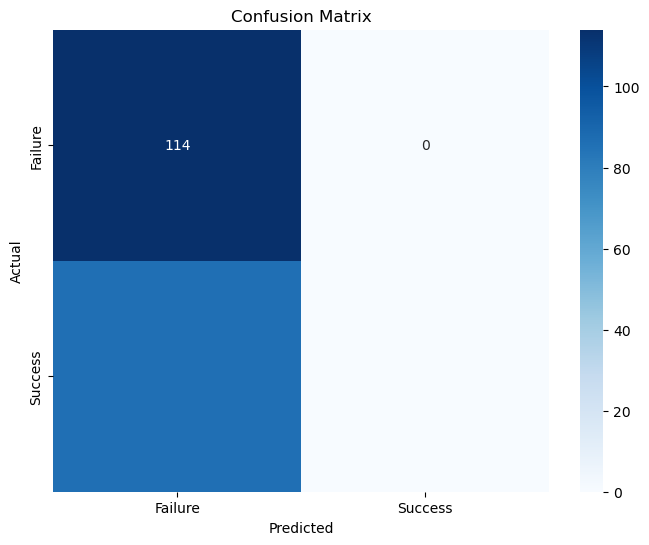

In [26]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Failure", "Success"], yticklabels=["Failure", "Success"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   -------- ------------------------------- 61.4/299.9 kB 1.7 MB/s eta 0:00:01
   ------------ --------------------------- 92.2/299.9 kB 1.1 MB/s eta 0:00:01
   ------------ ------------------------- 102.4/299.9 kB 845.5 kB/s eta 0:00:01
   ------------ ------------------------- 102.4/299.9 kB 845.5 kB/s eta 0:00:01
   ------------------------------- -------- 235.5/299.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 1.1 MB/s eta 0:00:00


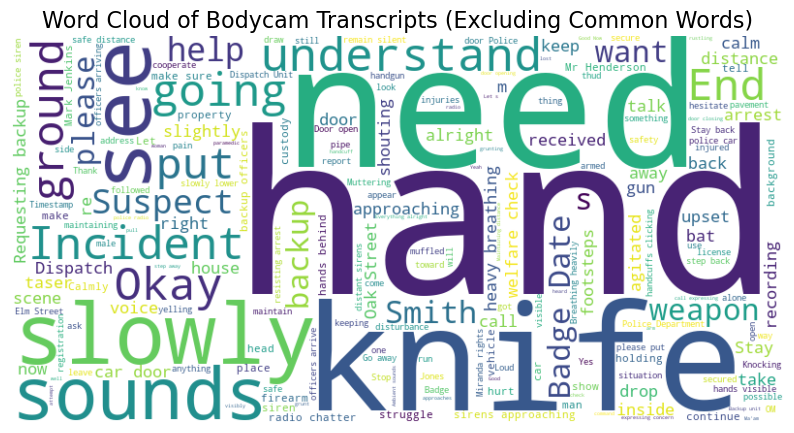

In [31]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["officer", "miller", "subject", "sound", "october", "time", "and", "john", "doe", "sir", "I", "Audio", "Bodycam", "Transcript"])

text_data = " ".join(val_texts)
wordcloud = WordCloud(
    width=800, height=400, background_color="white", stopwords=custom_stopwords, colormap="viridis"
).generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Bodycam Transcripts (Excluding Common Words)", fontsize=16)
plt.show()